In [1]:
# import matplotlib
# matplotlib.use('TkAgg')
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from functools import reduce
import csv
%matplotlib inline
from utils import *
import copy

from IPython.display import HTML
tog='''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''';
HTML(tog)

In [2]:
def fNdot(N,t,params):
    (s,i,r)=N;
    T,r0=params;
    ds=0.      -r0*s*i/T;
    di=r0*s*i/T-i/T;
    dr=i/T;
    return (ds,di,dr)

def vfield(axis,Ndot,num=20,scale=1/0.0015,norm_method='none',col=None):
    xlim=list(axis.get_xlim());
    ylim=list(axis.get_ylim());
    x=np.linspace(xlim[0],xlim[1],num);
    y=np.linspace(ylim[0],ylim[1],num);
    xs,ys=np.meshgrid(x,y);
    us,vs=Ndot(xs,ys);
    
    ls=(us**2+vs**2)**0.5;        
    if norm_method=='log':
        lls=np.min(np.log(ls),0);
        us=us/ls*lls;
        vs=vs/ls*lls;
    elif norm_method=='len':
        ls=(us**2+vs**2)**0.5;
        us=us/ls;
        vs=vs/ls;
    axis.quiver(xs,ys,us,vs,color=col,scale_units='inches',angles='xy',pivot='mid',scale=scale)




In [3]:

class intobj():
    def __init__(self,Ndot,N0,params):
        self.fcn=Ndot;
        self.ss,self.labels=N0;
        self.params=params;
    def evo(self,ts):
        self.ts=ts;
        Ns=odeint(self.fcn,self.ss,ts,args=(self.params,));
        self.Ns=Ns;
        return(Ns)
    def line(self,ax,idx):
        ax.plot(self.ts,self.Ns[:,idx],label=self.labels[idx]);
    def phase(self,ax,idx):
        xi,yi=idx;
        ax.plot(self.Ns[:,xi],self.Ns[:,yi]);
        ax.set_xlabel(self.labels[xi]);
        ax.set_ylabel(self.labels[yi]);
        


from scipy.interpolate import *

def readcsv(fname):
#     fname='measles_data.csv'
    csvdata={};

    with open(fname,'r') as  f:
        header=f.readline().rstrip('\n').split(',');
        lsts=[[]]*(len(header));
        for line in f.readlines():
            data=line.rstrip('\n').split(',');
            for i,k in enumerate(data):
    #             len(lsts)
                lsts[i]=lsts[i]+[float(k)];
    #     print(lsts)
        for i,lst in enumerate(lsts):
            csvdata[header[i]]=lst;
    #     print(len(lsts))
    return csvdata;
csvdata=readcsv('measles_data.csv')
time_years=csvdata['time'];
time_days=[round(x*365) for x in csvdata['time']];
Is=csvdata['infection'];


fname='EWpop_short.csv'
popcsv=readcsv(fname);
pop_pre=popcsv['pop'];
f=interp1d(list(x + 0.5 for x in popcsv['year']),pop_pre);
pop=f(time_years);


        

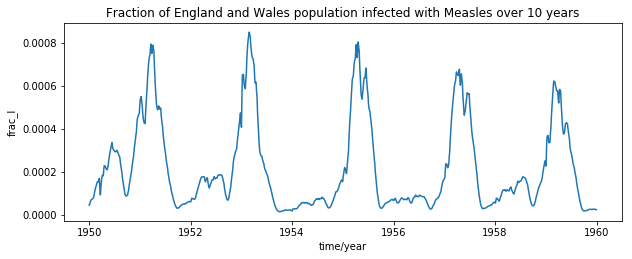

In [4]:
### figure 1
### visualise historical data
time_years=csvdata['time'];
time_days=[round(x*365) for x in csvdata['time']];
infection=csvdata['infection'];
Is=[x/y for x,y in zip(infection,pop)];
fig=plt.figure(figsize=[10,8]);
ax=plt.subplot(2,1,1);
ax.plot(time_years,Is);
ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
ax.set_xlabel('time/year')
ax.set_ylabel('frac_I')

# ax2.plot(time_years[0:1500],Is[0:1500]);
# ax2.set_title ('Fraction of England and Wales population infected with Measles over 1500 days')
# ax2.set_xlabel('time/year')
# ax2.set_ylabel('frac_I')


/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in divide
/home/shouldsee/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


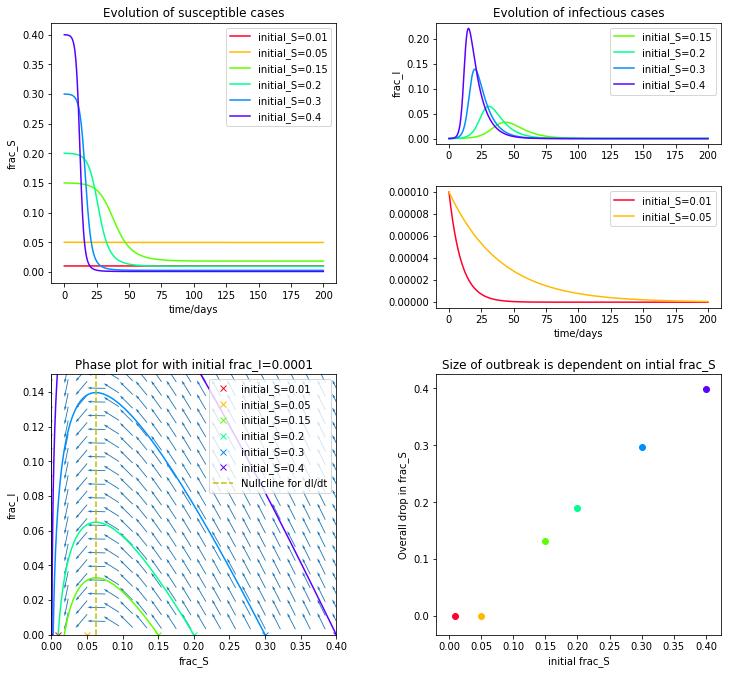

In [5]:
### figure 3
### simple SIR model
fig=plt.figure(figsize=[12,10]);

def fNdot(N,t,params):
#     tr=T, r0=r0;
    (s,i,r)=N;
    T,r0,k=params;
    ds=0.      -r0*s*i/T+k;
    di=r0*s*i/T-i/T;
    dr=i/T-k;
    return (ds,di,dr)
ax=plt.subplot(2,2,3);
ax2a=plt.subplot(4,2,2);
ax2b=plt.subplot(4,2,4);
ax1=plt.subplot(2,2,1);
ax4=plt.subplot(2,2,4);
cm = plt.get_cmap('gist_rainbow')

fss=[0.01,0.05,0.15,0.20,0.30,0.40];
fi=0.0001;
siz=len(fss);
params=(8.0, 16.0, 0.0000);
N0=[(.199,fi,0.800),('frac_S','frac_I','frac_R','time/days')];
s0=intobj(fNdot,N0,params);
runs=[];
for i in range(siz):
    fr=1-fss[i]-fi;
    s=copy.copy(s0);
    s.ss=(fss[i],fi,fr);
    s.evo(np.linspace(0,200,1001))
    runs+=[s];

for i in range(siz):
    s0=runs[i];
    col=cm(1.*i/(siz));
    lbl='initial_S='+str(fss[i])
    xs=s0.Ns[:,0];
    ys=s0.Ns[:,1];
    ts=s0.ts[:];
    
#     xs=s0.Ns[-10000:,0];
#     ys=s0.Ns[-10000:,1];
#     ts=s0.ts[-10000:];
    ax.plot(xs,ys,color=col);    
    ax.plot(s0.Ns[0,0],s0.Ns[0,1],'x',color=col,label=lbl);
#     ax.quiver(s0.Ns[50,0],s0.Ns[50,1],s0.Ns[50,0]-s0.Ns[50,0],s0.Ns[50,1]-s0.Ns[50,1],color=col,pivot='mid')
    if fss[i]> 1./params[1]:
        ax2a.plot(ts,ys,color=col,label=lbl);
    else:
        ax2b.plot(ts,ys,color=col,label=lbl);
    ax1.plot(ts,xs,color=col,label=lbl);
    
    ax4.scatter(fss[i],s0.Ns[0,0]-s0.Ns[-1,0],color=col);
#     col =  
#     s0.phase(ax,(0,1))
ax.set_xlabel(s0.labels[0]);
ax.set_ylabel(s0.labels[1]); 
ax.plot([1./params[1],1./params[1]],[0,1],'--y',label='Nullcline for dI/dt')
ax.set_title('Phase plot for with initial frac_I='+str(fi))
ax.legend()
ax.set_ylim(0,0.15)
ax.set_xlim(0,0.4)
vfunc=lambda x,y:fNdot((x,y,1-x-y),0,s0.params)[0:2];
vfield(ax,vfunc,20,2/0.5,'len')

ax1.set_ylabel(s0.labels[0]);
ax1.legend()
ax1.set_xlabel(s0.labels[-1]);
ax1.set_title('Evolution of susceptible cases')

ax2a.set_ylabel(s0.labels[1]);
ax2a.legend()
ax2b.legend()
# ax2.set_ylim([0 ,0.1])
ax2b.set_xlabel(s0.labels[-1]);
ax2a.set_title('Evolution of infectious cases')

ax4.set_ylabel('Overall drop in frac_S');
ax4.legend()
ax4.set_xlabel('initial frac_S');
ax4.set_title('Size of outbreak is dependent on intial frac_S')
plt.subplots_adjust(left=0.125, bottom=0.05, right=0.9, top=0.9,
                wspace=0.35, hspace=0.35)


# fig.savefig('task2_q7.png')


/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:85: RuntimeWarning: divide by zero encountered in double_scalars


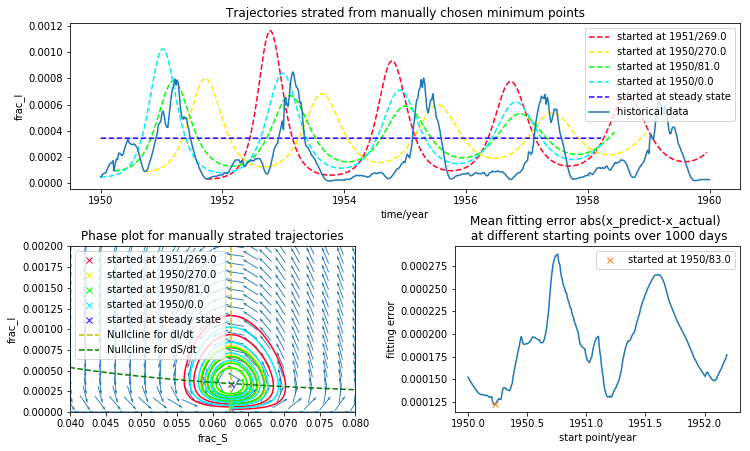

In [6]:
### figure 5
### characterising different start points for fitting
def fNdot(N,t,params):
#     tr=T, r0=r0;
    (s,i,r)=N;
    T,r0,k=params;
    ds=0.      -r0*s*i/T+k;
    di=r0*s*i/T-i/T;
    dr=i/T-k;
    return (ds,di,dr)

params=(8.0, 16.0, 4.29E-5);
# params=(8.0, 16.0, 4.29E-4);
T,r0,k=params;

fi=0.0001;
fis=[];
fis+=[min(Is[:1000])];
fis+=[min(Is[250:500])];
fis+=[min(Is[45:90])];
fis+=[Is[0]];
ids=list(Is.index(x) for x in fis);
t_sts=list( time_days[x] for x in ids);
# fss=[0.01,0.05,0.15,0.20, 0.25 ,0.30,1-fi];
# fss=[ 1/r0];
fis+=[T*k];
t_sts+=[time_days[0]];
fss=[ 1./r0]*len(fis);


siz=max(len(fss),len(fis))


N0=[(.199,0.01,0.800),('frac_S','frac_I','frac_R','time/days')];
s0=intobj(fNdot,N0,params);
runs=[];

for i in range(siz):
    fi=fis[i];fs=fss[i];t_st=t_sts[i];
    fr=1-fs-fi;
    s=copy.copy(s0);
    s.ss=(fs,fi,fr);
    s.evo(np.linspace(t_st,t_st+3000,3001))
    runs+=[s];
# s.Ns[-10,1]

# plt.cm.CMRmap[0]
fig=plt.figure(figsize=[12,10]);
# fig.set_size_inches([,10])
# help(fig)

ax=plt.subplot(3,2,3);
plt.subplots_adjust(left=0.125, bottom=0.05, right=0.9, top=0.9,
                wspace=0.35, hspace=0.35)
ax2=plt.subplot(3,1,1);
# ax1=plt.subplot(2,2,1);
# ax4=plt.subplot(3,2,4);
ax4=plt.subplot(3,2,4);
cm = plt.get_cmap('gist_rainbow')
for i in range(siz):
    s0=runs[i];
    col=cm(1.*i/(siz));
    xs=s0.Ns[:,0];
    ys=s0.Ns[:,1];
    ts=s0.ts[:];
    ts=list(x/365. for x in ts);
    if i+1==siz:
        lbl='started at steady state';
    else:    
        lbl='started at '+str(int(ts[0]))+'/'+str(round((ts[0]%1)*365));
    ax.plot(xs,ys,color=col);    
    ax.plot(s0.Ns[0,0],s0.Ns[0,1],'x',color=col,label=lbl);
#     ax.quiver(s0.Ns[50,0],s0.Ns[50,1],s0.Ns[50,0]-s0.Ns[50,0],s0.Ns[50,1]-s0.Ns[50,1],color=col,pivot='mid')

    ax2.plot(ts,ys,'--',color=col,label=lbl);
    ax1.plot(ts,xs,color=col,label=lbl);
    
#     ax4.scatter(fss[i],s0.Ns[0,0]-s0.Ns[-1,0],color=col);
#     col =  
#     s0.phase(ax,(0,1))
ax.set_xlabel(s0.labels[0]);
ax.set_ylabel(s0.labels[1]); 

xs=np.linspace(0,0.1,500);
ys=[T*k/r0/x for x in xs];
ax.plot([1./params[1],1./params[1]],[0,1],'--y',label='Nullcline for dI/dt')
ax.plot(xs,ys,'--g',label='Nullcline for dS/dt')
ax.set_title('Phase plot for manually strated trajectories')
ax.legend()
ax.set_ylim(0,0.002)
ax.set_xlim(0,0.1)
ax.set_xlim(.04,.08)
vfunc=lambda x,y:fNdot((x,y,1-x-y),0,s0.params)[0:2];
vfield(ax,vfunc,20,2/0.5,'len')

ax1.set_ylabel(s0.labels[0]);
ax1.legend()
ax1.set_xlabel(s0.labels[-1]);
ax1.set_title('Evolution of susceptible cases')

ax2.set_ylabel(s0.labels[1]);
# ax2.set_ylim([0 ,0.1])
ax2.set_xlabel(s0.labels[-1]);
# ax2.set_title('Evolution of infectious cases')
ax2.set_title('Trajectories strated from manually chosen minimum points')
ax2.plot(time_years,Is,label='historical data');
# ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
ax2.set_xlabel('time/year')
ax2.set_ylabel('frac_I')
ax2.legend()




params=(8.0, 16.0, 4.29E-5);
T,r0,k=params;
ids=list(range(0,800))
fis=list(Is[x] for x in ids);
t_sts=list( time_days[x] for x in ids);
fss=[ 1/r0]*len(fis);
siz=max(len(fss),len(fis))

## initialise the integration object
N0=[(.199,0.1,0.800),('frac_S','frac_I','frac_R','time/days')];
s0=intobj(fNdot,N0,params);
runs=[];
errs=[];

## start a 3000 steps simulation from all parameters in lists.
## Record fitting error in "errs".
for i in range(siz):
    fi=fis[i];fs=fss[i];t_st=t_sts[i];
    fr=1-fs-fi;
    s=copy.copy(s0);
    s.ss=(fs,fi,fr);
    s.evo(np.linspace(t_st,t_st+1000,1001))
    id_st=time_days.index(s.ts[0]);
    obs=Is[id_st:id_st+1001];
    errlst=list(abs(x-y) for x,y in zip(obs,s.Ns[:,1]))
    s.err=sum(errlst)/len(errlst)
    runs+=[s];
    errs+=[s.err];
    

# plt.close('all')
# fig=plt.figure(figsize=[12,5]);
# ax4=plt.subplot(1,1,1);
t_sts_years=list((x/365) for x in t_sts)
ax4.plot(t_sts_years,errs,'-');
ax4.set_title('Mean fitting error abs(x_predict-x_actual) \n at different starting points over 1000 days')
ax4.set_xlabel('start point/year')
ax4.set_ylabel('fitting error')

### identify the parameter with least fitting error
id1=errs.index(min(errs))
t=t_sts_years[id1];
lbl='started at '+str(int(t))+'/'+str(round((t%1)*365));
ax4.plot(t_sts_years[id1],errs[id1],'x',label=lbl);
ax4.legend()
                                      
# id2=errs.index(min(errs[500:1000]))

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


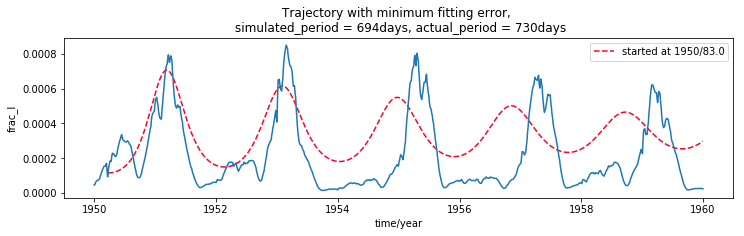

In [7]:
### figure 6
### restart the simulation with the identified parameter set.
ids=[id1,id1];
fis=list(Is[x] for x in ids);
t_sts=list( time_days[x] for x in ids);
fss=[ 1/r0]*len(fis);
siz=1;
# siz=len(ids);
N0=[(.199,0.01,0.800),('frac_S','frac_I','frac_R','time/days')];
s0=intobj(fNdot,N0,params);
runs=[];

for i in range(siz):
    fi=fis[i];fs=fss[i];t_st=t_sts[i];
    fr=1-fs-fi;
    s=copy.copy(s0);
    s.ss=(fs,fi,fr);
    t_end=max(t_st+3000,max(time_days));
    s.evo(np.linspace(t_st,t_end,round(t_end-t_st)+1))
    runs+=[s];
# s.Ns[-10,1]

# plt.cm.CMRmap[0]
fig=plt.figure(figsize=[12,10]);
# fig.set_size_inches([,10])
# help(fig)

# ax=plt.subplot(3,2,3);
ax56=plt.subplot(3,1,3);
# ax1=plt.subplot(2,2,1);
# ax4=plt.subplot(3,2,4);
cm = plt.get_cmap('gist_rainbow')
for i in range(siz):
    s0=runs[i];
    col=cm(1.*i/(siz));
    xs=s0.Ns[:,0];
    ys=s0.Ns[:,1];
    ts=s0.ts[:];
    ts=list(x/365. for x in ts);
    lbl='started at '+str(int(ts[0]))+'/'+str(round((ts[0]%1)*365));
#     ax.plot(xs,ys,color=col);    
#     ax.plot(s0.Ns[0,0],s0.Ns[0,1],'x',color=col,label=lbl);
#     ax.quiver(s0.Ns[50,0],s0.Ns[50,1],s0.Ns[50,0]-s0.Ns[50,0],s0.Ns[50,1]-s0.Ns[50,1],color=col,pivot='mid')

    ax56.plot(ts,ys,'--',color=col,label=lbl);


    
ys=list(s.Ns[:,1].flatten())
i1=ys.index(max(ys[:1000]))
i2=ys.index(max(ys[1000:2000]))
per_obs=i2-i1;

ys=list(Is)
i1=ys.index(max(ys[:1000]))
i2=ys.index(max(ys[1000:2000]))
# per_act=i2-i1;
per_act=730;


ax56.set_ylabel(s0.labels[1]);
ax56.legend()
# ax2.set_ylim([0 ,0.1])
ax56.set_xlabel(s0.labels[-1]);
ax56.set_title('Trajectory with minimum fitting error, \n simulated_period = '+str(per_obs)+'days'+', actual_period = '+str(per_act)+'days')
ax56.plot(time_years,Is);
# ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
ax56.set_xlabel('time/year')
ax56.set_ylabel('frac_I')

# ax4.set_ylabel('Overall drop in frac_S');
# ax4.legend()
# ax4.set_xlabel('initial frac_S');
# ax4.set_title('Size of outbreak is dependent on intial frac_S')
# fig.savefig('task2_q7.png')

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:86: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


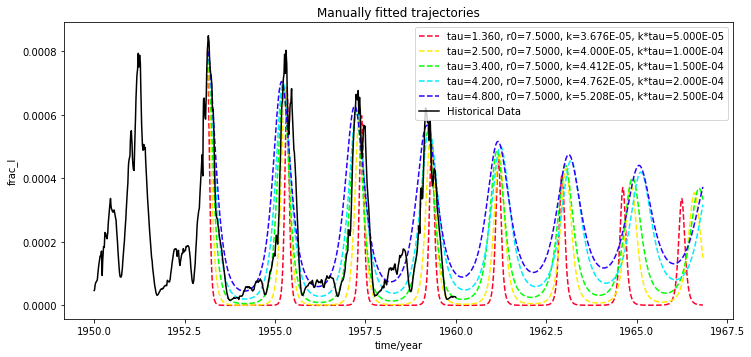

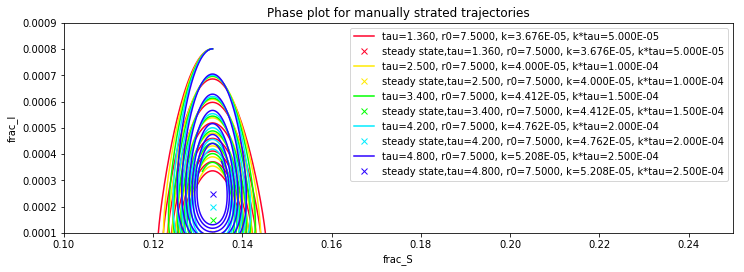

In [8]:
### figure 7
### explore the effect of tau (T) and k (k);
def fNdot(N,t,params):
#     tr=T, r0=r0;
    (s,i,r)=N;
    T,r0,k=params;
    ds=0.      -r0*s*i/T+k;
    di=r0*s*i/T-i/T;
    dr=i/T-k;
    return (ds,di,dr)


ids=[id1,id1];

id2=Is.index(max(Is[:1000]))
ids=[id2,id2];
fis=list(Is[x] for x in ids);
t_sts=list( time_days[x] for x in ids);
fss=[ 1/r0]*len(fis);
siz=max(len(fss),len(fis))
siz=1;
N0=[(.199,0.01,0.800),('frac_S','frac_I','frac_R','time/days')];
# s0=intobj(fNdot,N0,params);

runs=[];
perlst=[];

id2=Is.index(max(Is[1000:2000]))
# id2=id2-15;
id2=id2-10;

ids=[id2,id2];
# ids=[0,0];
fis=list(Is[x] for x in ids);
t_sts=list( time_days[x] for x in ids);
fss=[ 1/r0]*len(fis);
siz=max(len(fss),len(fis))
siz=1;
t_st=t_sts[0];
N0=[(.199,0.01,0.800),('frac_S','frac_I','frac_R','time/days')];
stepsize=1;

# s0=intobj(fNdot,N0,params);
# plt.close('all')
fig2=plt.figure(figsize=[12,12]);
ax56=plt.subplot(2,1,1);
fig3=plt.figure(figsize=[12,8.5]);
ax2=plt.subplot(2,1,1)
# ax1=plt.subplot(2,2,1);
# ax4=plt.subplot(3,2,4);
cm = plt.get_cmap('gist_rainbow')
# params=(T, 16.0, 4.29E-5);
params=(8.808, 16.0, 4.29E-5);
params=(3.400, 18.0, 4.4E-5);
plst=[];
T=1.36;
params=(T, 7.5, 5.0E-5/T);
plst+=[params];
T=2.5;
params=(T, 7.5, 10.0E-5/T);
plst+=[params];
T=3.4;
params=(T, 7.5, 15.0E-5/T);
plst+=[params];
T=4.2;
params=(T, 7.5, 20.0E-5/T);
plst+=[params];
T=4.8;
params=(T, 7.5, 25.0E-5/T);
plst+=[params];
# T=5.3;
# params=(T, 12.0, 20.96E-5/T);
# params=(T, 3.0, 34.32E-5/T);
# params=(1.700, 16.0, 8.8E-5);

# params=(6.800, 16.0, 2.2E-5);
# params=params_new;
for i in range(len(plst)):
    params=plst[i]
    T,r0,k=params;
    fs=1/r0;
    ss=(fs,fis[0],1-fs-fis[0])
    s0=intobj(fNdot,N0,params)
    s0.ss=ss;
    t_end=max(t_st+5000,max(time_days));
    s0.evo(np.linspace(t_st,t_end,round(t_end-t_st)*stepsize+1))
    lbl='tau=%.3f, r0=%.4f, k=%.3E, k*tau=%.3E'%(T,r0,k,k*T);
    col=cm(1.*i/len(plst));
    xs=s0.Ns[:,0];
    ys=s0.Ns[:,1];
    ts=s0.ts[:];
    ts=list(x/365. for x in ts);

    ax56.plot(ts,ys,'--',color=col,label=lbl);
    ax2.plot(xs[:5000],ys[:5000],color=col,label=lbl);
    ax2.plot(1./r0,T*k,'x',color=col,label='steady state,'+lbl);
ax2.legend()
ax2.set_title('Phase plot for manually strated trajectories')
ax2.set_xlabel('frac_S')
ax2.set_ylabel('frac_I')
ax2.set_xlim(0.1,.25)
ax2.set_ylim(0.0001,.0009)

ax56.set_ylabel(s0.labels[1]);
# ax2.set_ylim([0 ,0.1])
ax56.set_xlabel(s0.labels[-1]);
ax56.set_title('Manually fitted trajectories')
# ax56.set_title('Trajectory with minimum fitting error, \n simulated_period = '+str(per_obs)+'days'+', actual_period = '+str(per_act)+'days')
ax56.plot(time_years,Is,'black',label='Historical Data');
# ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
ax56.set_xlabel('time/year')
ax56.set_ylabel('frac_I')
ax56.legend()

# fig2=plt.figure(figsize=[12,12]);
# ax7=plt.subplot(2,1,2);
cm = plt.get_cmap('gist_rainbow')
plst=[];
T=3.4;
params=(T, 7.5, 14.96E-5/T);
plst+=[params]*2;

# T=5.3;
# params=(T, 12.0, 20.96E-5/T);
# params=(T, 3.0, 34.32E-5/T);
# params=(1.700, 16.0, 8.8E-5);

# params=(6.800, 16.0, 2.2E-5);
# # params=params_new;
# for i in range(1):
#     params=plst[i]
#     T,r0,k=params;
#     fs=1/r0;
#     ss=(fs,fis[0],1-fs-fis[0])
#     s0=intobj(fNdot,N0,params)
#     s0.ss=ss;
#     t_end=max(t_st+5000,max(time_days));
#     s0.evo(np.linspace(t_st,t_end,round(t_end-t_st)*stepsize+1))
#     lbl='tau=%.3f, r0=%.4f, k=%.3E '%(T,r0,k);
#     col=cm(1.*i/len(plst));
#     xs=s0.Ns[:,0];
#     ys=s0.Ns[:,1];
#     ts=s0.ts[:];
#     ts=list(x/365. for x in ts);
#     ax7.plot(ts,ys,'--',color=col,label=lbl);

# ax7.set_ylabel(s0.labels[1]);
# # ax2.set_ylim([0 ,0.1])
# ax7.set_xlabel(s0.labels[-1]);
# ax7.set_title('Manually fitted trajectories')
# # ax56.set_title('Trajectory with minimum fitting error, \n simulated_period = '+str(per_obs)+'days'+', actual_period = '+str(per_act)+'days')
# ax7.plot(time_years,Is,'black',label='Historical Data');
# ax7.legend()
# # ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
# ax7.set_xlabel('time/year')
# ax7.set_ylabel('frac_I')


/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:84: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:138: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


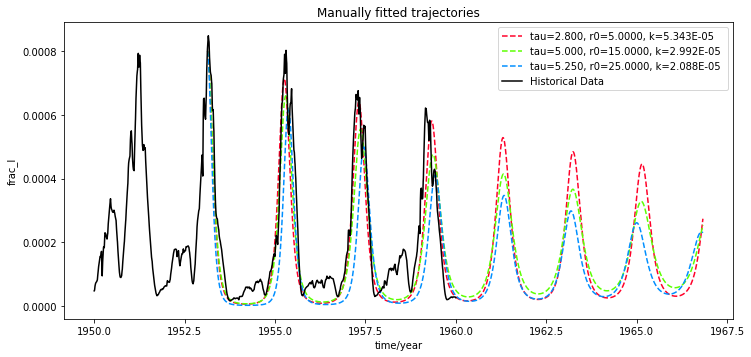

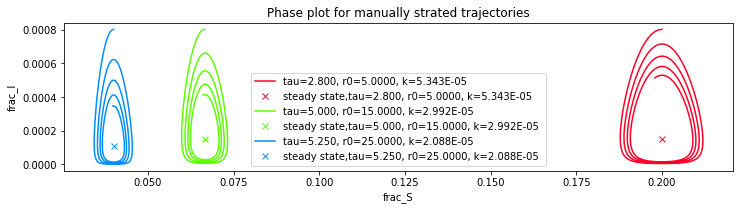

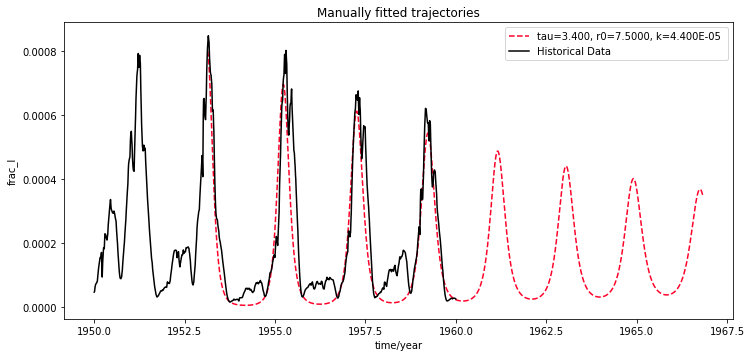

In [9]:
### figure 8
### explore the effect of r0 (r0);
def fNdot(N,t,params):
#     tr=T, r0=r0;
    (s,i,r)=N;
    T,r0,k=params;
    ds=0.      -r0*s*i/T+k;
    di=r0*s*i/T-i/T;
    dr=i/T-k;
    return (ds,di,dr)


ids=[id1,id1];

id2=Is.index(max(Is[:1000]))
ids=[id2,id2];
fis=list(Is[x] for x in ids);
t_sts=list( time_days[x] for x in ids);
fss=[ 1/r0]*len(fis);
siz=max(len(fss),len(fis))
siz=1;
N0=[(.199,0.01,0.800),('frac_S','frac_I','frac_R','time/days')];
# s0=intobj(fNdot,N0,params);

runs=[];
perlst=[];

id2=Is.index(max(Is[1000:2000]))
# id2=id2-15;
id2=id2-10;

ids=[id2,id2];
# ids=[0,0];
fis=list(Is[x] for x in ids);
t_sts=list( time_days[x] for x in ids);
fss=[ 1/r0]*len(fis);
siz=max(len(fss),len(fis))
siz=1;
t_st=t_sts[0];
N0=[(.199,0.01,0.800),('frac_S','frac_I','frac_R','time/days')];
# s0=intobj(fNdot,N0,params);
# plt.close('all')
fig2=plt.figure(figsize=[12,12]);
ax56=plt.subplot(2,1,1);
fig3=plt.figure(figsize=[12,6]);
ax2=plt.subplot(2,1,1);
# ax1=plt.subplot(2,2,1);
# ax4=plt.subplot(3,2,4);
cm = plt.get_cmap('gist_rainbow')
# params=(T, 16.0, 4.29E-5);
params=(8.808, 16.0, 4.29E-5);
params=(3.400, 18.0, 4.4E-5);
plst=[];
# T=1.21;
# params=(T, 1.0, 14.96E-5/T);
# plst+=[params];
T=2.8;
params=(T, 5.0, 14.96E-5/T);
plst+=[params];
T=5.0;
params=(T, 15.0, 14.96E-5/T);
plst+=[params];
# T=4.05;
# params=(T, 15.0, 10.96E-5/T);
# plst+=[params];
T=5.25;
params=(T, 25.0, 10.96E-5/T);
plst+=[params];
# T=5.3;
# params=(T, 12.0, 20.96E-5/T);
# params=(T, 3.0, 34.32E-5/T);
# params=(1.700, 16.0, 8.8E-5);

# params=(6.800, 16.0, 2.2E-5);
# params=params_new;
for i in range(len(plst)):
    params=plst[i]
    T,r0,k=params;
    fs=1/r0;
    ss=(fs,fis[0],1-fs-fis[0])
    s0=intobj(fNdot,N0,params)
    s0.ss=ss;
    t_end=max(t_st+5000,max(time_days));
    s0.evo(np.linspace(t_st,t_end,round(t_end-t_st)*stepsize+1))
    lbl='tau=%.3f, r0=%.4f, k=%.3E '%(T,r0,k);
    col=cm(1.*i/len(plst));
    xs=s0.Ns[:,0];
    ys=s0.Ns[:,1];
    ts=s0.ts[:];
    ts=list(x/365. for x in ts);

    ax56.plot(ts,ys,'--',color=col,label=lbl);
    ax2.plot(xs[:3000],ys[:3000],color=col,label=lbl);
    ax2.plot(1./r0,T*k,'x',color=col,label='steady state,'+lbl);
ax2.legend()
ax2.set_title('Phase plot for manually strated trajectories')
ax2.set_xlabel('frac_S')
ax2.set_ylabel('frac_I')
# ax2.legend()
# ax2.set_ylim(0,0.002)
# ax2.set_xlim(0,0.1)
# ax2.set_xlim(.04,.08)

ax56.set_ylabel(s0.labels[1]);
# ax2.set_ylim([0 ,0.1])
ax56.set_xlabel(s0.labels[-1]);
ax56.set_title('Manually fitted trajectories')
# ax56.set_title('Trajectory with minimum fitting error, \n simulated_period = '+str(per_obs)+'days'+', actual_period = '+str(per_act)+'days')
ax56.plot(time_years,Is,'black',label='Historical Data');
# ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
ax56.set_xlabel('time/year')
ax56.set_ylabel('frac_I')
ax56.legend()

fig2=plt.figure(figsize=[12,12]);
ax7=plt.subplot(2,1,2);
cm = plt.get_cmap('gist_rainbow')
plst=[];
T=3.4;
params=(T, 7.5, 14.96E-5/T);
plst+=[params]*2;

# T=5.3;
# params=(T, 12.0, 20.96E-5/T);
# params=(T, 3.0, 34.32E-5/T);
# params=(1.700, 16.0, 8.8E-5);

# params=(6.800, 16.0, 2.2E-5);
# params=params_new;
for i in range(1):
    params=plst[i]
    T,r0,k=params;
    fs=1/r0;
    ss=(fs,fis[0],1-fs-fis[0])
    s0=intobj(fNdot,N0,params)
    s0.ss=ss;
    t_end=max(t_st+5000,max(time_days));
    s0.evo(np.linspace(t_st,t_end,round(t_end-t_st)*stepsize+1))
    lbl='tau=%.3f, r0=%.4f, k=%.3E '%(T,r0,k);
    col=cm(1.*i/len(plst));
    xs=s0.Ns[:,0];
    ys=s0.Ns[:,1];
    ts=s0.ts[:];
    ts=list(x/365. for x in ts);
    ax7.plot(ts,ys,'--',color=col,label=lbl);
   

ax7.set_ylabel(s0.labels[1]);
# ax2.set_ylim([0 ,0.1])
ax7.set_xlabel(s0.labels[-1]);
ax7.set_title('Manually fitted trajectories')
# ax56.set_title('Trajectory with minimum fitting error, \n simulated_period = '+str(per_obs)+'days'+', actual_period = '+str(per_act)+'days')
ax7.plot(time_years,Is,'black',label='Historical Data');
ax7.legend()
# ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
ax7.set_xlabel('time/year')
ax7.set_ylabel('frac_I')

In [10]:
idx=[i for (i,t) in enumerate(ts) if t>1953 and t<1956 ];
ts0=ts;
ys0=ys;
xs0=xs;
ts=list(ts[i] for i in idx);
ys=list(ys[i] for i in idx);
xs=list(xs[i] for i in idx);

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in double_scalars


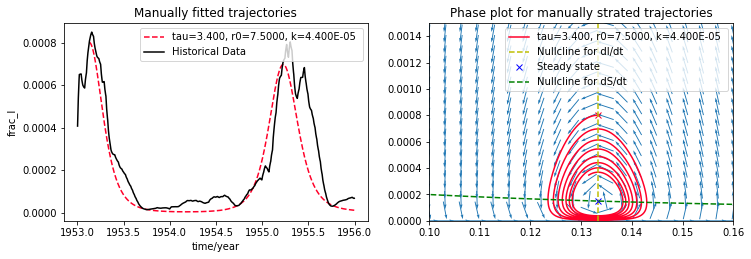

In [11]:
### figure 9
### restart the simulation with optimised parameter
fig=plt.figure(figsize=[12,8])
ax7=plt.subplot(2,2,1);
ax7.plot(ts,ys,'--',color=col,label=lbl);
ax7.set_ylabel(s0.labels[1]);
# ax2.set_ylim([0 ,0.1])
ax7.set_xlabel(s0.labels[-1]);
ax7.set_title('Manually fitted trajectories')
# ax56.set_title('Trajectory with minimum fitting error, \n simulated_period = '+str(per_obs)+'days'+', actual_period = '+str(per_act)+'days')
idx=[i for (i,t) in enumerate(time_years) if t>1953 and t<1956 ];
ax7.plot(list(time_years[i] for i in idx),list(Is[i] for i in idx),'black',label='Historical Data');
ax7.legend()
# ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
ax7.set_xlabel('time/year')
ax7.set_ylabel('frac_I')

ax=plt.subplot(2,2,2);
ax.plot(xs[0],ys[0],'x',color=col);
ax.plot(xs0,ys0,color=col,label=lbl);
hxs=np.linspace(0,0.3,500);
T,r0,k=params;
hys=[T*k/r0/x for x in hxs];
ax.plot([1./params[1],1./params[1]],[0,.1],'--y',label='Nullcline for dI/dt')
ax.plot(1./r0,T*k,'bx',label='Steady state')
ax.plot(hxs,hys,'--g',label='Nullcline for dS/dt')
ax.set_title('Phase plot for manually strated trajectories')
ax.legend()
ax.set_ylim(0,0.0015)
ax.set_xlim(0.1,0.16)
# ax.set_xlim(.04,.08)
vfunc=lambda x,y:fNdot((x,y,1-x-y),0,s0.params)[0:2];
vfield(ax,vfunc,20,2/0.5,'len')

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:68: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:112: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


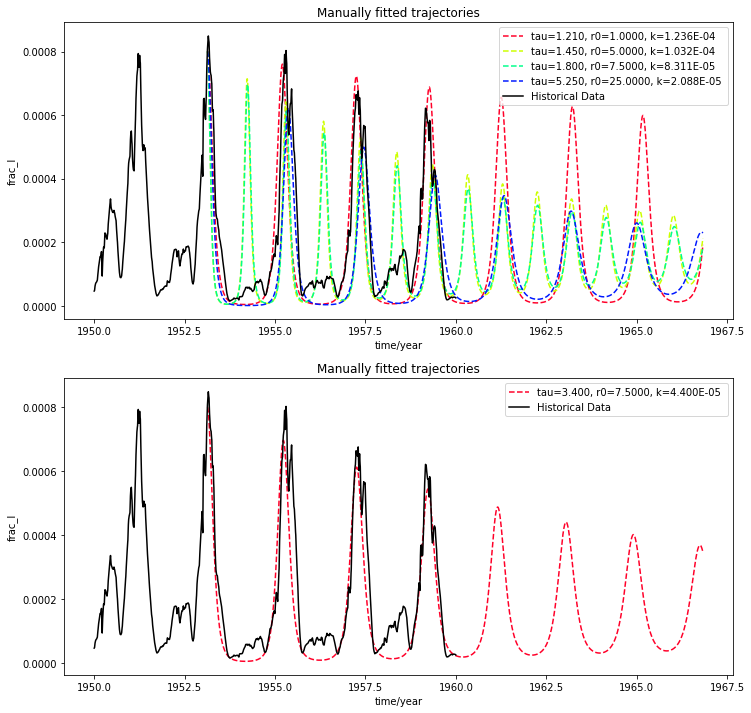

In [12]:
### further experiments

def fNdot(N,t,params):
#     tr=T, r0=r0;
    (s,i,r)=N;
    T,r0,k=params;
    ds=0.      -r0*s*i/T+k;
    di=r0*s*i/T-i/T;
    dr=i/T-k;
    return (ds,di,dr)


id2=Is.index(max(Is[1000:2000]))
# id2=id2-15;
id2=id2-10;

ids=[id2,id2];
# ids=[0,0];
fis=list(Is[x] for x in ids);
t_sts=list( time_days[x] for x in ids);
fss=[ 1/r0]*len(fis);
siz=max(len(fss),len(fis))
siz=1;
t_st=t_sts[0];
N0=[(.199,0.01,0.800),('frac_S','frac_I','frac_R','time/days')];
# s0=intobj(fNdot,N0,params);
# plt.close('all')
fig2=plt.figure(figsize=[12,12]);
ax56=plt.subplot(2,1,1);
# ax1=plt.subplot(2,2,1);
# ax4=plt.subplot(3,2,4);
cm = plt.get_cmap('gist_rainbow')
# params=(T, 16.0, 4.29E-5);
params=(8.808, 16.0, 4.29E-5);
params=(3.400, 18.0, 4.4E-5);
plst=[];
T=1.21;
params=(T, 1.0, 14.96E-5/T);
plst+=[params];
T=1.45;
params=(T, 5.0, 14.96E-5/T);
plst+=[params];
T=1.8;
params=(T, 7.5, 14.96E-5/T)
# params=(T, 15.0, 14.96E-5/T);
plst+=[params];
# T=4.05;
# params=(T, 15.0, 10.96E-5/T);
# plst+=[params];
T=5.25;
params=(T, 25.0, 10.96E-5/T);
plst+=[params];
# T=5.3;
# params=(T, 12.0, 20.96E-5/T);
# params=(T, 3.0, 34.32E-5/T);
# params=(1.700, 16.0, 8.8E-5);

# params=(6.800, 16.0, 2.2E-5);
# params=params_new;
for i in range(len(plst)):
    params=plst[i]
    T,r0,k=params;
    fs=1/r0;
    ss=(fs,fis[0],1-fs-fis[0])
    s0=intobj(fNdot,N0,params)
    s0.ss=ss;
    t_end=max(t_st+5000,max(time_days));
    s0.evo(np.linspace(t_st,t_end,round(t_end-t_st)*stepsize+1))
    lbl='tau=%.3f, r0=%.4f, k=%.3E '%(T,r0,k);
    col=cm(1.*i/len(plst));
    xs=s0.Ns[:,0];
    ys=s0.Ns[:,1];
    ts=s0.ts[:];
    ts=list(x/365. for x in ts);

    ax56.plot(ts,ys,'--',color=col,label=lbl);

ax56.set_ylabel(s0.labels[1]);
# ax2.set_ylim([0 ,0.1])
ax56.set_xlabel(s0.labels[-1]);
ax56.set_title('Manually fitted trajectories')
# ax56.set_title('Trajectory with minimum fitting error, \n simulated_period = '+str(per_obs)+'days'+', actual_period = '+str(per_act)+'days')
ax56.plot(time_years,Is,'black',label='Historical Data');
# ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
ax56.set_xlabel('time/year')
ax56.set_ylabel('frac_I')
ax56.legend()

# fig2=plt.figure(figsize=[12,12]);
ax7=plt.subplot(2,1,2);
cm = plt.get_cmap('gist_rainbow')
plst=[];
T=3.4;
params=(T, 7.5, 14.96E-5/T);
plst+=[params]*2;

# T=5.3;
# params=(T, 12.0, 20.96E-5/T);
# params=(T, 3.0, 34.32E-5/T);
# params=(1.700, 16.0, 8.8E-5);

# params=(6.800, 16.0, 2.2E-5);
# params=params_new;
for i in range(1):
    params=plst[i]
    T,r0,k=params;
    fs=1/r0;
    ss=(fs,fis[0],1-fs-fis[0])
    s0=intobj(fNdot,N0,params)
    s0.ss=ss;
    t_end=max(t_st+5000,max(time_days));
    s0.evo(np.linspace(t_st,t_end,round(t_end-t_st)*stepsize+1))
    lbl='tau=%.3f, r0=%.4f, k=%.3E '%(T,r0,k);
    col=cm(1.*i/len(plst));
    xs=s0.Ns[:,0];
    ys=s0.Ns[:,1];
    ts=s0.ts[:];
    ts=list(x/365. for x in ts);
    ax7.plot(ts,ys,'--',color=col,label=lbl);

ax7.set_ylabel(s0.labels[1]);
# ax2.set_ylim([0 ,0.1])
ax7.set_xlabel(s0.labels[-1]);
ax7.set_title('Manually fitted trajectories')
# ax56.set_title('Trajectory with minimum fitting error, \n simulated_period = '+str(per_obs)+'days'+', actual_period = '+str(per_act)+'days')
ax7.plot(time_years,Is,'black',label='Historical Data');
ax7.legend()
# ax.set_title ('Fraction of England and Wales population infected with Measles over 10 years')
ax7.set_xlabel('time/year')
ax7.set_ylabel('frac_I')